# Initialize databank

In [1]:
import sys
import seaborn as sns

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../Data/MD-PERMEATION/'
db_data = databank(path)
systems = db_data.get_systems()

/home/samuli/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


# Define functions

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sn
import os
import scipy.stats
from scipy import stats
import scipy.optimize
import math

def CalcAreaPerMolecule(system):
    path = system['path']
    APLpath = path.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    APLpath = APLpath + 'apl.json'
    #try:
    f = open(APLpath)
    APLdata = json.load(f)
    sumAPL = 0
    sumIND = 0
    for i,j in APLdata.items():
        sumAPL += j
        sumIND += 1
    APL = sumAPL/sumIND
    return(APL)
    #except:
    #    print('apl.json not found from' + APLpath)

def getBoxZ(system):
    path = system['path']
    BoxZpath = path.replace('../Data/MD-PERMEATION/', '../Data/BoxZ/')
    BoxZpath = BoxZpath + 'BoxZ.json'
    #try:
    f = open(BoxZpath)
    BoxZdata = json.load(f)
    sumBoxZ = 0
    sumIND = 0
    for i,j in BoxZdata.items():
        sumBoxZ += j
        sumIND += 1
    BoxZ = sumBoxZ/sumIND
    return(BoxZ)

    
def calcArea(system):
    APL = CalcAreaPerMolecule(system)
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return Nlipid*APL/2

def GetThickness(system):
    path = system['path']
    ThicknessPath = path.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    ThicknessPath = ThicknessPath + 'thickness.json'
    #try:
    f = open(ThicknessPath)
    thickness = json.load(f)
    return(thickness)
    #except:
    #    pass
    #    print('thickness.json not found from' + system['path'])
    

def calcLipidFraction(system, lipid):
    NlipidTOT = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NlipidTOT += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if lipid in molecule:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Nlipid/NlipidTOT

def chargedFraction(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Ncharged = 0
    chargedlipids = ['POPG', 'POPS', 'DPPG', 'DOPS', 'POPI', 'SAPI', 'SLPI', 'DHMDMAB']
    for molecule in system['COMPOSITION']:
        if molecule in chargedlipids:
            Ncharged += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Ncharged/Nlipid


def getHydrationLevel(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    Nwater = system['COMPOSITION']['SOL']['COUNT']
    return Nwater/Nlipid


def getWaterPermeationRate(system):
    path = system['path']
    with open(path + 'Counting_events.txt', 'r') as f:
        last_line = f.readlines()[-1]
    last_line = last_line.split()
    time = float(last_line[0])
    count = float(last_line[1])
    area = calcArea(system)
    #rate = count / (time * area)  #1/(ns*Å^2)
    rate = count / (time)  #1/ns
    thickness = GetThickness(system)*10
    Nwater = system['COMPOSITION']['SOL']['COUNT']
    P = 0.5*rate*10**9/(area*10**-20 * 33.3679*10**27)
    return P*10**6  # micrometer per second

def getWaterDiffusionThroughMembrane(system):
    #with open(path + 'Counting_events.txt', 'r') as f:
    #    last_line = f.readlines()[-1]
    #last_line = last_line.split()
    #time = float(last_line[0])
    #count = float(last_line[1])
    #area = calcArea(system)
    #rate = count / (time * area)  #1/(ns*Å^2)
    #rate = count / (time)  #1/ns
    thickness = GetThickness(system)
    #Nwater = system['COMPOSITION']['SOL']['COUNT']
    
    LateralDiffusion = getWaterLateralDiffusion(system)*10**-9 #m^2/s
    Permeation = getWaterPermeationRate(system)*10**-6 #m/s
    WaterThickness = (getBoxZ(system) - thickness)*10**-10 #m
    
    D = LateralDiffusion*Permeation*WaterThickness/(LateralDiffusion + Permeation * WaterThickness)
    return D*10**9 # 10^-9 m^2/s
    #D= 0.5*rate*10**9*(thickness*10**-9)**2 # m²/s
    #return D*10**4*10**5 # (10^-5 * cm^2)/s

def getWaterLateralDiffusion(system):
    path = system['path']
    waterDIFFUSIONpath = path.replace('../Data/MD-PERMEATION/', '../Data/WATERdiffusion/')
    waterDIFFUSIONpath = waterDIFFUSIONpath + 'WATERlateralMSD.xvg'
    D = float(os.popen('grep D ' + waterDIFFUSIONpath + " | grep = | awk '{print $5}'").read())
    return D # 10^-9 m^2/s
    
def plotCorrelation(xProperty,yProperty,permeationResults):
    xPropertyData = []
    yPropertyData = []
    for ID in permeationResults:
        xPropertyData.append(permeationResults[ID][xProperty])
        yPropertyData.append(permeationResults[ID][yProperty])
    plt.plot(xPropertyData,yPropertyData,'.')
    
def plotXaveragedData(xProperty,yProperty,permeationResults,rounddec,MinimumDataLength):
    avetemp = {}
    for ID in permeationResults:
        #print(permeationVStemperature[ID])
        temperature = round(permeationVStemperature[ID][xProperty], rounddec)
        if temperature not in avetemp.keys():
            avetemp[temperature] = {}
            avetemp[temperature]['values'] = []
            avetemp[temperature]['weigths'] = []
        avetemp[temperature]['values'].append(permeationVStemperature[ID][yProperty])
        avetemp[temperature]['weigths'].append(permeationVStemperature[ID]['SimLenght']) 
        #print(permeationVStemperature[ID]['permeation'], permeationVStemperature[ID]['temperature'])
    
    xPropertyData = []
    yPropertyData = []
    yPropertyDataError = []
    for temp in avetemp:
        #if len(avetemp[temp]['values']) < 3:
        #    continue
        if np.sum(avetemp[temp]['weigths']) < MinimumDataLength:
            continue
        average = np.average(avetemp[temp]['values'], weights = avetemp[temp]['weigths'])
        variance = np.average((avetemp[temp]['values']-average)**2, weights = avetemp[temp]['weigths'])
        xPropertyData.append(temp)
        yPropertyData.append(average)
        yPropertyDataError.append(math.sqrt(variance)/math.sqrt(len(avetemp[temp]['values'])))
        #yPropertyDataError.append(math.sqrt(variance))
    #print(yPropertyDataError)
    plt.errorbar(xPropertyData,yPropertyData, yerr=yPropertyDataError, marker = ".", linestyle='', markersize =15, color = 'black')
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel('P (\u03bcm/s)', fontsize = 18)
    #plt.show()
    #plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='')
    return xPropertyData,yPropertyData,yPropertyDataError     
    
def averageOrderParameters(system):
    
    #DataBankPath = '../../Databank/Data/'
    #path = DataBankPath + system['path']
    
    pathTMP = system['path']
    path = pathTMP.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    
    sn1sum = 0
    sn1count = 0
    sn2sum = 0
    sn2count = 0
    
    for lipid in system['COMPOSITION']:
        if lipid in lipids_dict and not 'CHOL' in lipid:
            OPpathSIM = path + lipid + 'OrderParameters.json'
            with open(OPpathSIM) as json_file:
                OPsim = json.load(json_file)
    
            for key in OPsim:
                if 'M_G1C' in key:
                    sn1sum += float(OPsim[key][0][0])
                    sn1count += 1
                elif 'M_G2C' in key:
                    sn2sum += float(OPsim[key][0][0])
                    sn2count += 1
                    
    return -sn1sum/sn1count, -sn2sum/sn2count



# Create dictionary containing the data under interest

In [4]:
permeationVStemperature = {}
ID = 0
for system in systems:
    path = system['path']
    
    #DPPCFraction = calcLipidFraction(system, 'DSPC')
    #if DPPCFraction != 1:
    #    continue
    
    #if 'CLA' in system['COMPOSITION'].keys() and system['COMPOSITION']['CLA']['COUNT'] > 0:
    #    continue
    
    
    try:
        rate = getWaterPermeationRate(system)
    except:
        #print('Water permeation failed, setting rate to 0: ' + path)
        rate = 0
        #continue
    
    if rate == 0:
        continue
    
    #if system['TEMPERATURE'] < 320:
    #    print(system['TEMPERATURE'], path)
    
    
    WaterLateralDiffusion = getWaterLateralDiffusion(system)
    
    #if WaterLateralDiffusion > 15:
    #    print(path)
    #    print('Water diffusion larger than 15: ', WaterLateralDiffusion)
    #    continue
    
    DiffThroughMem = getWaterDiffusionThroughMembrane(system)
    #print(DiffThroughMem, WaterLateralDiffusion)
    DiffAniso = DiffThroughMem / WaterLateralDiffusion
    
    #if rate > 0:
    PermeationDiffusionRatio = rate/WaterLateralDiffusion
    #else:
    #    PermeationDiffusionRatio = 'nan'
    
    APL = CalcAreaPerMolecule(system)
    
    try:
        thickness = GetThickness(system)
    except:
        thickness = 0 #float('nan')

    #if thickness < 3:
    #    continue
        
    area = calcArea(system)   
    
    tailOPavg = np.average(averageOrderParameters(system))
    #print(tailOPavg)
    if str(tailOPavg) == 'nan':
        print(system)
    
    sn1OPavg = averageOrderParameters(system)[0]
    sn2OPavg = averageOrderParameters(system)[1]
    
    hydration = getHydrationLevel(system)
    
    CholFraction = calcLipidFraction(system, 'CHOL')
    
    POPGFraction = calcLipidFraction(system, 'POPG')
    
    POPSFraction = calcLipidFraction(system, 'POPS')
    
    POPEFraction = calcLipidFraction(system, 'POPE')
    
    ChargedFraction = chargedFraction(system)
    
    temperature = system['TEMPERATURE']
    
    #if temperature > 315 or temperature < 300:
    #    continue
    
    SimLength = system['TRJLENGTH'] - system['PREEQTIME']
    
    try:
        ForceField = system['FF']
    except:
        ForceField = 'Unknown'
    
    if thickness == 0:
        continue
    
    ID += 1
    permeationVStemperature[ID] = {
        'path': path, 
        'permeation': rate, 
        'WaterLateralDiffusion' : WaterLateralDiffusion,
        'DiffThroughMem' : DiffThroughMem,
        'DiffAniso' : DiffAniso,
        'APL': float(APL), 
        'volume': APL*thickness,
        'thickness': thickness,
        'TailOrder' : float(tailOPavg),
        #'sn1Order' : sn1OPavg,
        #'sn2Order' : sn2OPavg,
        'hydration': float(hydration),
        'temperature': temperature ,
        'ChargedFraction': float(ChargedFraction),
        'CholFraction': float(CholFraction),
        'POPGFraction': float(POPGFraction),
        'POPSFraction': float(POPSFraction),
        'POPEFraction': float(POPEFraction),
        #'DSPCFraction': float(DPPCFraction),
        'ForceField': ForceField,
        'SimLenght': SimLength,
        'PermeationDiffusionRatio' : PermeationDiffusionRatio,
        'area' : float(area),
    }

FileNotFoundError: [Errno 2] No such file or directory: '../Data/BoxZ/492/100/492100cdfee39e4b427f1f4563c635839b40c2a4/b14f6e506122f9754896c3edb69f0fa9075272fb/BoxZ.json'

In [32]:
import yaml
file = open('/home/samuli/Dropbox/NMRlipids/DataBank/DSPCpermeationDATA.yaml','w')
yaml.dump(permeationVStemperature, file)
file.close()
permeationVStemperature

{1: {'path': '../Data/MD-PERMEATION/933/d66/933d66dc22f3196b8d56e067fc9ca51ad41b3421/3165c6c4e946e82550cde8d754a8260961652f5b/',
  'permeation': 10.449233377895206,
  'WaterLateralDiffusion': 5.8827,
  'DiffThroughMem': 9.656067458986414e-05,
  'DiffAniso': 1.6414346233849106e-05,
  'APL': 50.85244325027871,
  'volume': 274.083445825863,
  'thickness': 5.389779296875,
  'TailOrder': 0.2989444820816888,
  'hydration': 40.0,
  'temperature': 333.0,
  'ChargedFraction': 0.0,
  'CholFraction': 0.0,
  'POPGFraction': 0.0,
  'POPSFraction': 0.0,
  'POPEFraction': 0.0,
  'DSPCFraction': 1.0,
  'ForceField': 'CHARMM36',
  'SimLenght': 639800.0,
  'PermeationDiffusionRatio': 1.7762648746145828,
  'area': 13018.22547207135},
 2: {'path': '../Data/MD-PERMEATION/e6f/dde/e6fdde993fda386ebdfae3a429f94172f8cefd6f/931bba90c11699a1da26d12352e084d20424172e/',
  'permeation': 44.68534025678141,
  'WaterLateralDiffusion': 6.3792,
  'DiffThroughMem': 0.00035255324612142166,
  'DiffAniso': 5.526605939952057

In [ ]:
permeationVStemperatureFiltered = {}
for ID in permeationVStemperature:
    temperature =  permeationVStemperature[ID]['temperature']
    if temperature > 315 or temperature < 300:
        continue
    else:
        permeationVStemperatureFiltered[ID] = permeationVStemperature[ID]

# Calculate mean and median permeability, and plot distribution

In [ ]:
perm = []
sumIND = 0
sumPERM = 0
for i in permeationVStemperature:
    permeation = permeationVStemperature[i]['permeation']
    perm.append(permeation)
    sumPERM += permeationVStemperature[i]['permeation']
    sumIND += 1
    #sumPERM += permeationVStemperature[i]['SimLenght'] * permeationVStemperature[i]['permeation']
    #sumIND += permeationVStemperature[i]['SimLenght']
print(sumPERM/sumIND)

print(np.median(perm))

sns.distplot(perm)

#print(perm)
#perm.sort()
#for i in perm:
#    print(i)

# Plot permeation vs. area per lipid

In [ ]:
plotCorrelation('APL','permeation',permeationVStemperature)
result = plotXaveragedData('APL','permeation',permeationVStemperature,0,1000000)
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Area per lipid (Å²)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-2,85])
plt.savefig('../figures/APLvsPERMEATION.pdf')
plt.show()

plotCorrelation('APL','permeation',permeationVStemperature)
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Area per lipid (Å²)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
plt.xlim([40,70])
plt.ylim([-0.5,20])
#plt.ylim([-2,85])
plt.savefig('../figures/APLvsPERMEATIONzoomed.pdf')
plt.show()

# Plot permation vs. membrane thickness

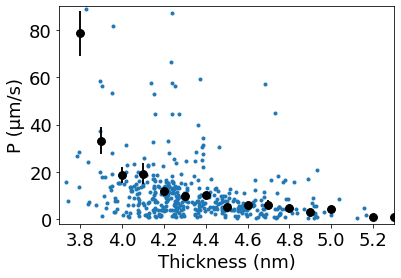

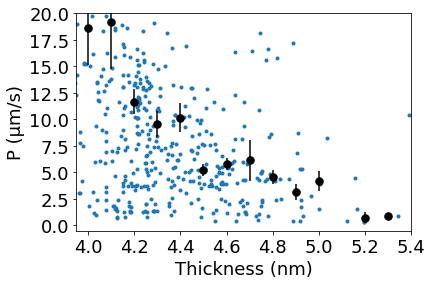

In [36]:
plotCorrelation('thickness','permeation',permeationVStemperature)
result = plotXaveragedData('thickness','permeation',permeationVStemperature,1,1000000)
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Thickness (nm)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
plt.xlim([3.7,5.3])
#plt.ylim([-0.5,20])
plt.ylim([-2,90])
plt.savefig('../figures/THICKNESSvsPERMEATION.pdf')
plt.show()

plotCorrelation('thickness','permeation',permeationVStemperature)
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Thickness (nm)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
plt.xlim([3.95,5.4])
plt.ylim([-0.5,20])
#plt.ylim([-2,85])
plt.savefig('../figures/THICKNESSvsPERMEATIONzoomed.pdf')
plt.show()

#plt.xlim([3.95,5.3])
#plt.ylim([0,20])

# Plot permeation vs. temperature

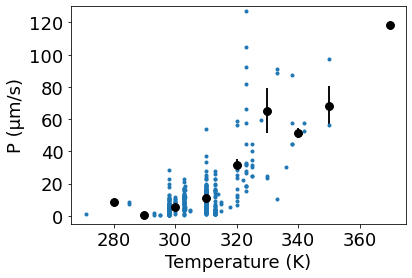

LinregressResult(slope=-4.941816510857016, intercept=18.419227759874587, rvalue=-0.8474666941746345, pvalue=0.003918217111530489, stderr=1.1699993138538598, intercept_stderr=3.6839890050562567)
-4.941816510857016
18.419227759874587
-0.8474666941746345
0.003918217111530489
1.1699993138538598


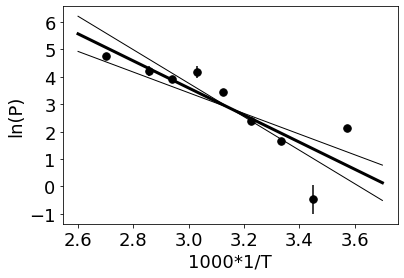

-16.58327688207052 3.9261721941404693


In [27]:
plotCorrelation('temperature','permeation',permeationVStemperature)
result = plotXaveragedData('temperature','permeation',permeationVStemperature,-1,1000000)
#plt.ylim([-10,10])
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Temperature (K)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
#plt.xlim([40,66])
plt.ylim([-5,130])
plt.savefig('../figures/TEMPERATUREvsPERMEATION.pdf')
plt.show()

#plt.show()

itemp = []
logP = []
logPerror = []
for i in range(len(result[0])):
    itemp.append(1000*1/result[0][i])
    logP.append(np.log(result[1][i]))
    logPerror.append(result[2][i] / result[1][i])
    #plt.plot(1/results[0][i],np.log(results[1][i]),".")

plt.errorbar(itemp,logP, yerr=logPerror, marker = ".", linestyle='', markersize =15, color = 'black')
fitResult = scipy.stats.linregress(itemp, logP)
print(fitResult)
#slope, intercept, rvalue, pvalue, stderr, intercept_stderr = fitResult
#print(fitResult.intercept_stderr)
for i in fitResult:
    print(i)
#print(fitResult[4])
x = np.linspace(2.6,3.7,20)
plt.plot(x, fitResult[0]*x + fitResult[1], color = 'black', lw = 3)
plt.plot(x, (fitResult[0]-fitResult[4])*x + fitResult[1]+fitResult.intercept_stderr, color = 'black', lw = 1)
plt.plot(x, (fitResult[0]+fitResult[4])*x + fitResult[1]-fitResult.intercept_stderr, color = 'black', lw = 1)
plt.xlabel('1000*1/T', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('ln(P)', fontsize = 18)
plt.savefig('../figures/TEMPERATUREvsPERMEATIONafit.pdf')
plt.show()


print(1000*fitResult[0] / 298, 1000*fitResult[4] / 298)



# Plot permeation vs. tail order 

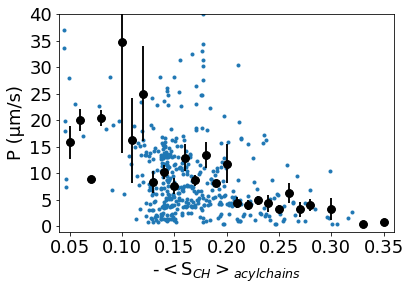

In [38]:
plotCorrelation('TailOrder','permeation',permeationVStemperature)
result = plotXaveragedData('TailOrder','permeation',permeationVStemperature,2,1000000)
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.ylim([-1,40])
plt.xlabel('-$<$S$_{CH}>_{acyl chains}$', fontsize = 18)
#ax.set_xlabel('-$<$S$>_{acyl chains}$', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
plt.xlim([0.04,0.36])
#plt.ylim([-0.5,20])
#plt.ylim([-2,85])
plt.savefig('../figures/CHAINORDERvsPERMEATION.pdf')
plt.show()


# Plot permeation vs. hydration or different lipid fractions

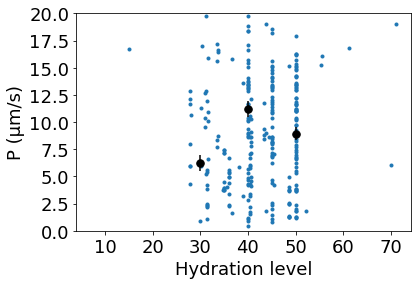

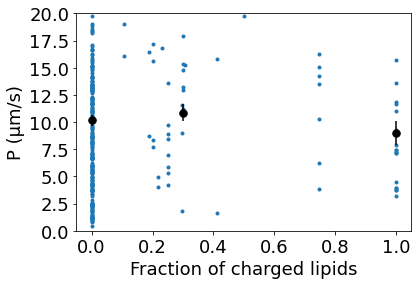

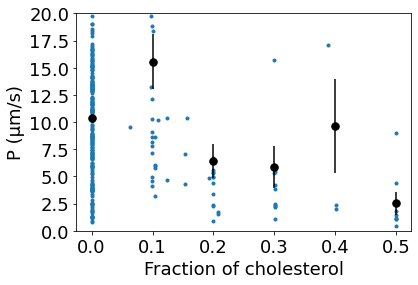

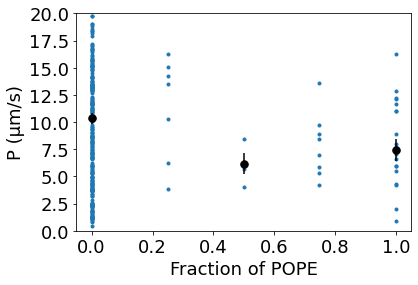

In [40]:
plotCorrelation('hydration','permeation',permeationVStemperatureFiltered)
result = plotXaveragedData('hydration','permeation',permeationVStemperatureFiltered,-1,1000000)
#plt.xticks(fontsize = 18)
#plt.yticks(fontsize = 18)
plt.xlabel('Hydration level', fontsize = 18)
plt.ylim([0,20])
plt.savefig('../figures/HYDRATIONvsPERMEATION.pdf')
plt.show()

plotCorrelation('ChargedFraction','permeation',permeationVStemperatureFiltered)
result = plotXaveragedData('ChargedFraction','permeation',permeationVStemperatureFiltered,1,1000000)
plt.xlabel('Fraction of charged lipids', fontsize = 18)
plt.ylim([0,20])
plt.savefig('../figures/CHARGEDvsPERMEATION.pdf')
plt.show()

plotCorrelation('CholFraction','permeation',permeationVStemperatureFiltered)
result = plotXaveragedData('CholFraction','permeation',permeationVStemperatureFiltered,1,1000000)
plt.xlabel('Fraction of cholesterol', fontsize = 18)
plt.ylim([0,20])
plt.savefig('../figures/CHOLESTEROLvsPERMEATION.pdf')
plt.show()

#plotCorrelation('POPGFraction','permeation',permeationVStemperatureFiltered)
#result = plotXaveragedData('POPGFraction','permeation',permeationVStemperatureFiltered,1)
#plt.ylim([0,20])
#plt.show()

#plotCorrelation('POPSFraction','permeation',permeationVStemperatureFiltered)
#result = plotXaveragedData('POPSFraction','permeation',permeationVStemperatureFiltered,1)
#plt.ylim([0,20])
#plt.show()

plotCorrelation('POPEFraction','permeation',permeationVStemperatureFiltered)
result = plotXaveragedData('POPEFraction','permeation',permeationVStemperatureFiltered,1,1000000)
plt.xlabel('Fraction of POPE', fontsize = 18)
plt.ylim([0,20])
plt.savefig('../figures/POPEvsPERMEATION.pdf')
plt.show()

# Plot translational diffusion vs. temperature

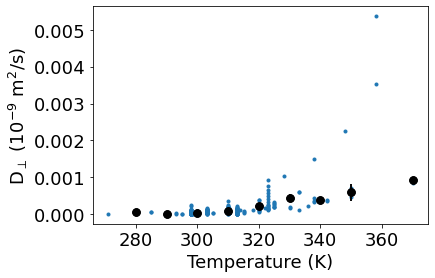

LinregressResult(slope=-4.945138258096557, intercept=-14.0681402406382, rvalue=-0.8761083777933344, pvalue=0.001948405684577157, stderr=1.0285407816175012, intercept_stderr=3.238577053733323)
-4.945138258096557
-14.0681402406382
-0.8761083777933344
0.001948405684577157
1.0285407816175012


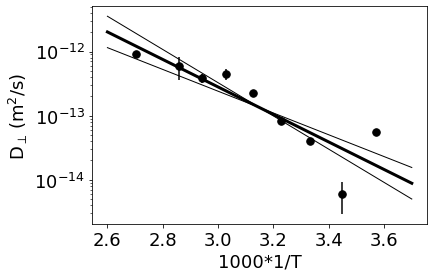

-16.594423684887772 3.451479132944635


In [118]:
plotCorrelation('temperature','DiffThroughMem',permeationVStemperature)
result = plotXaveragedData('temperature','DiffThroughMem',permeationVStemperature,-1,1000000)
#plt.ylim([-10,10])
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Temperature (K)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('D$_\perp$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-5,130])
plt.savefig('../figures/TEMPERATUREvsTRANSDIFFUSION.pdf')
plt.show()

#plt.show()
    
itemp = []
logP = []
logPerror = []
P = []
Perror = []
for i in range(len(result[0])):
    itemp.append(1000*1/result[0][i])
    logP.append(math.log(result[1][i]*10**-9))
    P.append(result[1][i]*10**-9)
    logPerror.append(result[2][i] / result[1][i])
    Perror.append(result[2][i]*10**-9)
    

#plt.errorbar(itemp,logP, yerr=logPerror, marker = ".", linestyle='', markersize =15, color = 'black')
plt.errorbar(itemp,P, yerr=Perror, marker = ".", linestyle='', markersize =15, color = 'black')
fitResult = scipy.stats.linregress(itemp, logP)
print(fitResult)
#slope, intercept, rvalue, pvalue, stderr, intercept_stderr = fitResult
#print(fitResult.intercept_stderr)
for i in fitResult:
    print(i)
#print(fitResult[4])
x = np.linspace(2.6,3.7,20)
plt.plot(x, np.exp(fitResult[0]*x + fitResult[1]), color = 'black', lw = 3)
plt.plot(x, np.exp((fitResult[0]-fitResult[4])*x + fitResult[1]+fitResult.intercept_stderr), color = 'black', lw = 1)
plt.plot(x, np.exp((fitResult[0]+fitResult[4])*x + fitResult[1]-fitResult.intercept_stderr), color = 'black', lw = 1)
plt.xlabel('1000*1/T', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('D$_\perp\,(\mathrm{m}^2$/s)', fontsize = 18)
plt.yscale('log',base=10)
plt.savefig('../figures/TEMPERATUREvsTRANSDIFFUSIONfit.pdf')
plt.show()


print(1000*fitResult[0] / 298, 1000*fitResult[4] / 298)



# Water lateral diffusion as a function of temperature

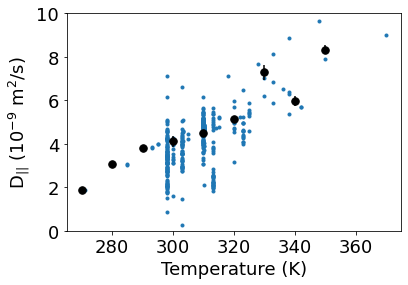

LinregressResult(slope=-1.5686719084024046, intercept=-14.111690260928004, rvalue=-0.9752701621782595, pvalue=3.322468944521079e-07, stderr=0.11849767056412405, intercept_stderr=0.37584988816875914)
-1.5686719084024046
-14.111690260928004
-0.9752701621782595
3.322468944521079e-07
0.11849767056412405


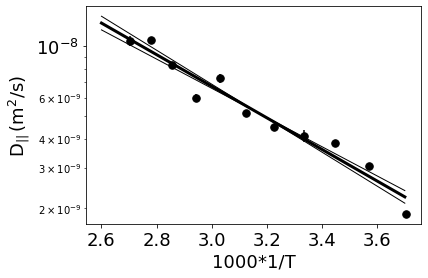

-5.263999692625519 0.3976431898124968


In [122]:
plotCorrelation('temperature','WaterLateralDiffusion',permeationVStemperature)
result = plotXaveragedData('temperature','WaterLateralDiffusion',permeationVStemperature,-1,0)
plt.ylabel('D$_{||}$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
plt.xlabel('Temperature (K)', fontsize = 18)
plt.ylim([-0,10])
plt.savefig('../figures/TEMPERATUREvsLATERALDIFFUSION.pdf')
plt.show()

itemp = []
logP = []
logPerror = []
P = []
Perror = []
for i in range(len(result[0])):
    itemp.append(1000*1/result[0][i])
    logP.append(math.log(result[1][i]*10**-9))
    P.append(result[1][i]*10**-9)
    logPerror.append(result[2][i] / result[1][i])
    Perror.append(result[2][i]*10**-9)
    #plt.plot(1/results[0][i],np.log(results[1][i]),".")

#plt.errorbar(itemp,logP, yerr=logPerror, marker = ".", linestyle='', markersize =15, color = 'black')
plt.errorbar(itemp,P, yerr=Perror, marker = ".", linestyle='', markersize =15, color = 'black')
fitResult = scipy.stats.linregress(itemp, logP)
print(fitResult)
#slope, intercept, rvalue, pvalue, stderr, intercept_stderr = fitResult
#print(fitResult.intercept_stderr)
for i in fitResult:
    print(i)
#print(fitResult[4])
x = np.linspace(2.6,3.7,20)
plt.plot(x, np.exp(fitResult[0]*x + fitResult[1]), color = 'black', lw = 3)
plt.plot(x, np.exp((fitResult[0]-fitResult[4])*x + fitResult[1]+fitResult.intercept_stderr), color = 'black', lw = 1)
plt.plot(x, np.exp((fitResult[0]+fitResult[4])*x + fitResult[1]-fitResult.intercept_stderr), color = 'black', lw = 1)
plt.xlabel('1000*1/T', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('D$_{||}\,(\mathrm{m}^2$/s)', fontsize = 18)
plt.yscale('log',base=10)
plt.savefig('../figures/TEMPERATUREvsLATERALDIFFUSIONfit.pdf')

# This is experimental data for bulk water diffusion

#ExpData_x = [3.005057471264368, 3.0533333333333332, 3.1006896551724137, 3.1498850574712645, 3.1995402298850575, 3.250574712643678, 3.3029885057471264, 3.359080459770115, 3.413793103448276]
#ExpData_y = [4.641588833612773e-9, 4.281332398719396e-9, 3.844105707405486e-9, 3.4983209357750324e-9, 3.1410584890748986e-9, 2.7825594022071257e-9, 2.5665913434124953e-9, 2.213243715758717e-9, 1.9606391068744616e-9]

#plt.plot(ExpData_x,ExpData_y,'.', markersize =15, color = 'red')
#fitResultExp = scipy.stats.linregress(ExpData_x, np.log(ExpData_y))
#plt.plot(x, np.exp(fitResultExp[0]*x + fitResultExp[1]), color = 'red', lw = 3)
##plt.plot(x, np.exp((fitResultExp[0]-fitResultExp[4])*x + fitResultExp[1]+fitResultExp.intercept_stderr), color = 'red', lw = 1)
##plt.plot(x, np.exp((fitResultExp[0]+fitResultExp[4])*x + fitResultExp[1]-fitResultExp.intercept_stderr), color = 'red', lw = 1)
##print(fitResultExp)

plt.show()


print(1000*fitResult[0] / 298, 1000*fitResult[4] / 298)
#print(1000*fitResultExp[0] / 298, 1000*fitResultExp[4] / 298)


# Water lateral diffusion as a function of hydration

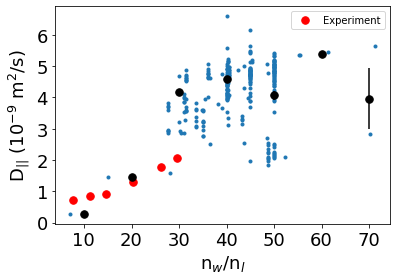

In [62]:
plotCorrelation('hydration','WaterLateralDiffusion',permeationVStemperatureFiltered)
result = plotXaveragedData('hydration','WaterLateralDiffusion',permeationVStemperatureFiltered,-1,0)
plt.ylabel('D$_{||}$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
plt.xlabel('n$_w$/n$_l$', fontsize = 18)
#plt.ylim([0,11])

ExperimentalData = [     #From Fig 3 a in https://doi.org/10.1007/BF03166747
    [17.04, 0.71],
    [22.97, 0.84],
    [27.93, 0.92],
    [35.00, 1.29],
    [40.99, 1.79],
    [43.98, 2.06]
]

def wtTOmolratio(wt):
    Mw = 18.015
    Ml = 677.9
    molratio = Ml/(Mw*(1/wt-1))
    return molratio

HydrationLevel = []
Diffusion = []
for i in ExperimentalData:
    HydrationLevel.append(wtTOmolratio(i[0]*0.01))
    MAfactor = np.sin(np.radians(54.7356))**2
    #Diffusion.append(i[1]/MAfactor)
    Diffusion.append(i[1])

plt.plot(HydrationLevel,Diffusion,'.',color='red', markersize =15, label = 'Experiment')
plt.legend()
#print(HydrationLevel,Diffusion)
plt.savefig('../figures/HYDRATIONvsLATERALDIFFUSION.pdf')

# Water lateral diffusion as a function of area per lipid, thickness, charged lipid fraction

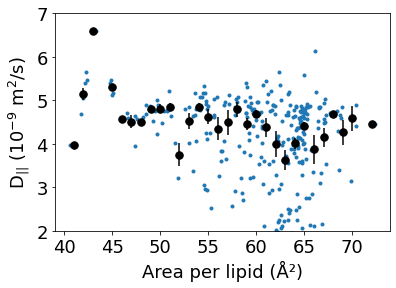

In [123]:
plotCorrelation('APL','WaterLateralDiffusion',permeationVStemperatureFiltered)
result = plotXaveragedData('APL','WaterLateralDiffusion',permeationVStemperatureFiltered,0,0)
plt.ylabel('D$_{||}$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
plt.xlabel('Area per lipid (Å²)', fontsize = 18)
plt.ylim([2,7])
plt.savefig('../figures/APLvsLATERALDIFFUSION.pdf')

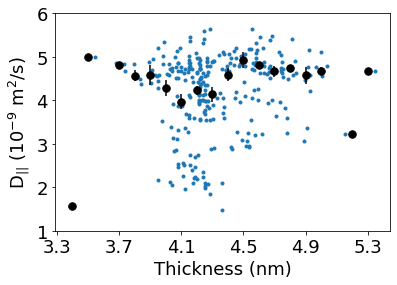

In [124]:
plotCorrelation('thickness','WaterLateralDiffusion',permeationVStemperatureFiltered)
result = plotXaveragedData('thickness','WaterLateralDiffusion',permeationVStemperatureFiltered,1,0)
plt.ylabel('D$_{||}$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
plt.xticks(np.arange(3.3, 5.4, 0.4))
plt.xlabel('Thickness (nm)', fontsize = 18)
#plt.xlim([3.3,5.3])
plt.ylim([1,6])
plt.savefig('../figures/THICKNESSvsLATERALDIFFUSION.pdf')

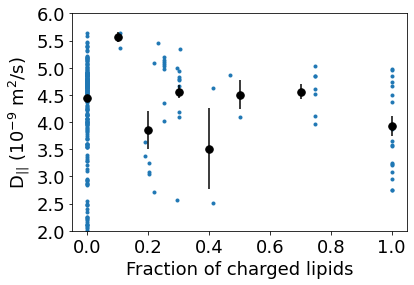

In [125]:
plotCorrelation('ChargedFraction','WaterLateralDiffusion',permeationVStemperatureFiltered)
result = plotXaveragedData('ChargedFraction','WaterLateralDiffusion',permeationVStemperatureFiltered,1,0)
plt.ylabel('D$_{||}$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
#plt.xticks(np.arange(3.3, 5.4, 0.4))
plt.xlabel('Fraction of charged lipids', fontsize = 18)
#plt.xlim([3.3,5.3])
plt.ylim([2,6])
plt.savefig('../figures/CHARGEDvsLATERALDIFFUSION.pdf')

# Diffusion anisotropy

(0.0, 0.0001)

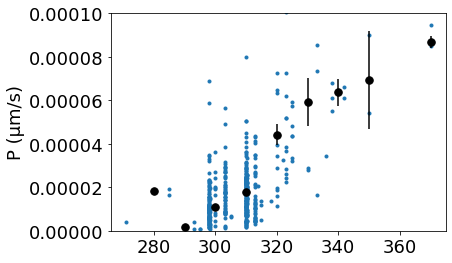

In [67]:
plotCorrelation('temperature','DiffAniso',permeationVStemperature)
result = plotXaveragedData('temperature','DiffAniso',permeationVStemperature,-1,1000000)
plt.ylim([0,0.0001])
#plt.xlim([3.8,5.3])

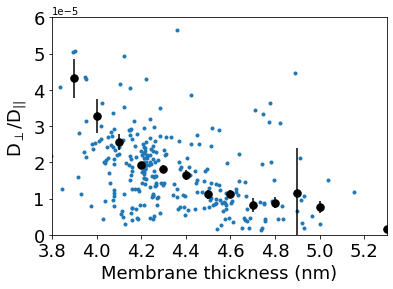

In [16]:
plotCorrelation('thickness','DiffAniso',permeationVStemperatureFiltered)
result = plotXaveragedData('thickness','DiffAniso',permeationVStemperatureFiltered,1,1000000)
plt.ylabel('D$_{\perp}$/D$_{||}$ ', fontsize = 18)
plt.xlabel('Membrane thickness (nm)', fontsize = 18)
plt.ylim([0,0.00006])
plt.xlim([3.8,5.3])
plt.savefig('../figures/THICKNESSvsDIFFUSIONANISOT.pdf')

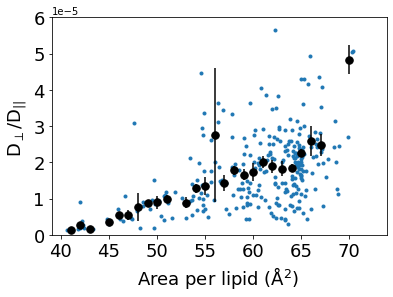

In [128]:
plotCorrelation('APL','DiffAniso',permeationVStemperatureFiltered)
result = plotXaveragedData('APL','DiffAniso',permeationVStemperatureFiltered,0,1000000)
plt.ylabel('D$_{\perp}$/D$_{||}$ ', fontsize = 18)
plt.xlabel('Area per lipid (Å$^2$) ', fontsize = 18)
plt.ylim([0,0.00006])
plt.savefig('../figures/APLvsDIFFUSIONANISOT.pdf')

(0.0, 6e-05)

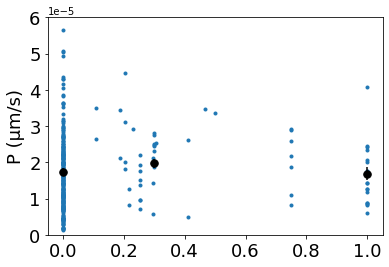

In [70]:
#print(permeationVStemperature)

plotCorrelation('ChargedFraction','DiffAniso',permeationVStemperatureFiltered)
result = plotXaveragedData('ChargedFraction','DiffAniso',permeationVStemperatureFiltered,1,1000000)
plt.ylim([0,0.00006])

(0.0, 6e-05)

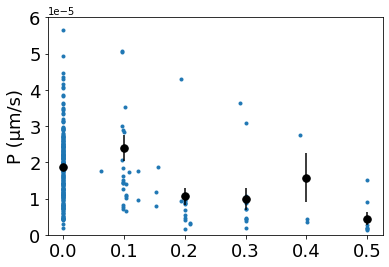

In [71]:
plotCorrelation('CholFraction','DiffAniso',permeationVStemperatureFiltered)
result = plotXaveragedData('CholFraction','DiffAniso',permeationVStemperatureFiltered,1,1000000)
plt.ylim([0,0.00006])

# Permation-diffusion ratio

(3.8, 5.3)

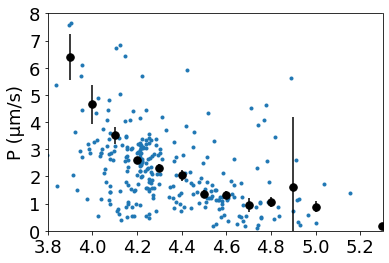

In [72]:
plotCorrelation('thickness','PermeationDiffusionRatio',permeationVStemperatureFiltered)
result = plotXaveragedData('thickness','PermeationDiffusionRatio',permeationVStemperatureFiltered,1,1000000)
plt.ylim([0,8])
plt.xlim([3.8,5.3])

(0.0, 8.0)

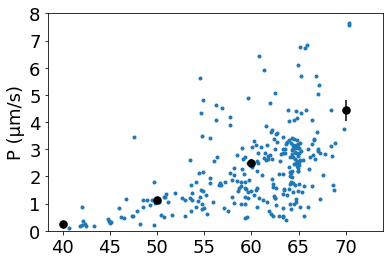

In [73]:
plotCorrelation('APL','PermeationDiffusionRatio',permeationVStemperatureFiltered)
result = plotXaveragedData('APL','PermeationDiffusionRatio',permeationVStemperatureFiltered,-1,1000000)
plt.ylim([0,8])
#plt.xlim([3.8,5.3])

# Area per lipid vs. thickness

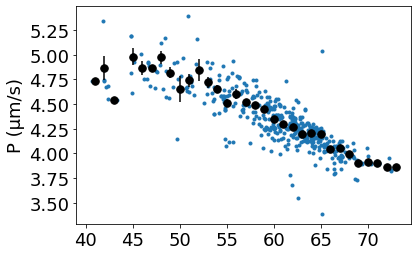

In [74]:
plotCorrelation('APL','thickness',permeationVStemperature)
result = plotXaveragedData('APL','thickness',permeationVStemperature,0,0)

In [56]:
data = {}
for prop in permeationVStemperature[1]:
    if prop == 'path':
        continue
    data[prop] = []

for ID in permeationVStemperature:
    for prop in permeationVStemperature[ID]:
        if prop == 'path':
            continue
        data[prop].append(permeationVStemperature[ID][prop])
        #print(ID,prop)

columns = []
for i in data:
    columns.append(i)

df = pd.DataFrame(data,columns=columns)
#print (df)

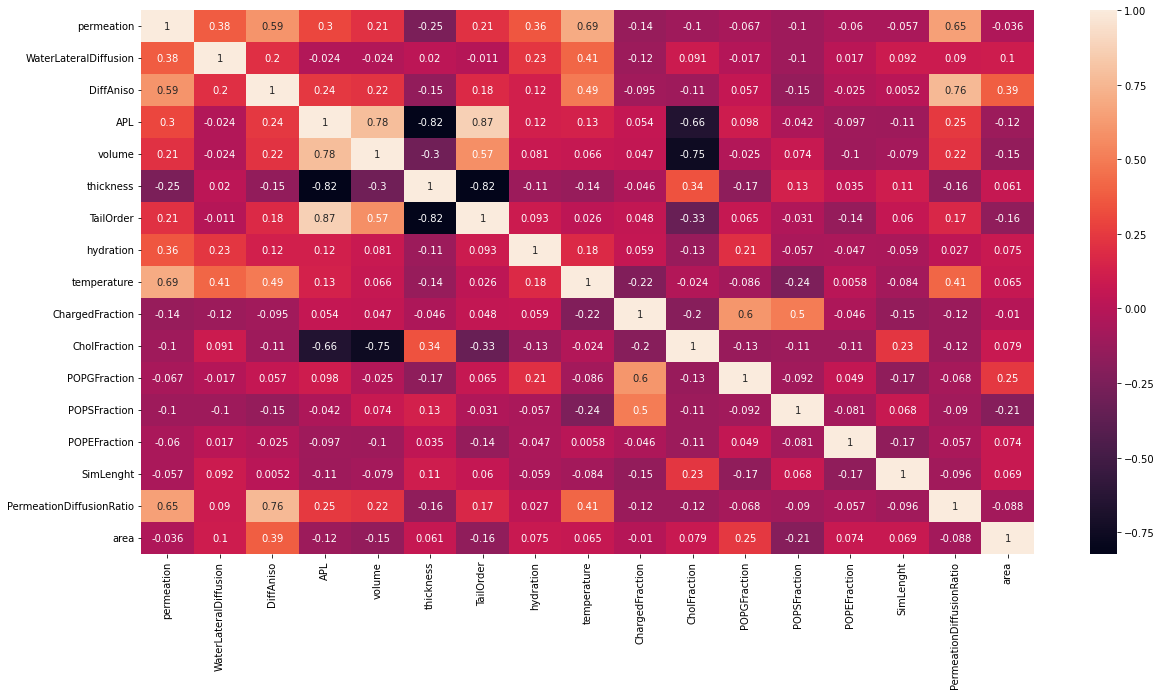

In [57]:
corrMatrix = df.corr()
#print (corrMatrix)
plt.figure(figsize = (20,10))
sn.heatmap(corrMatrix, annot=True)

plt.show()


In [ ]:
scipy.stats.pearsonr(data['ChargedFraction'],data['APL'])

In [ ]:
scipy.stats.spearmanr(data['ChargedFraction'],data['APL'])

In [ ]:
df

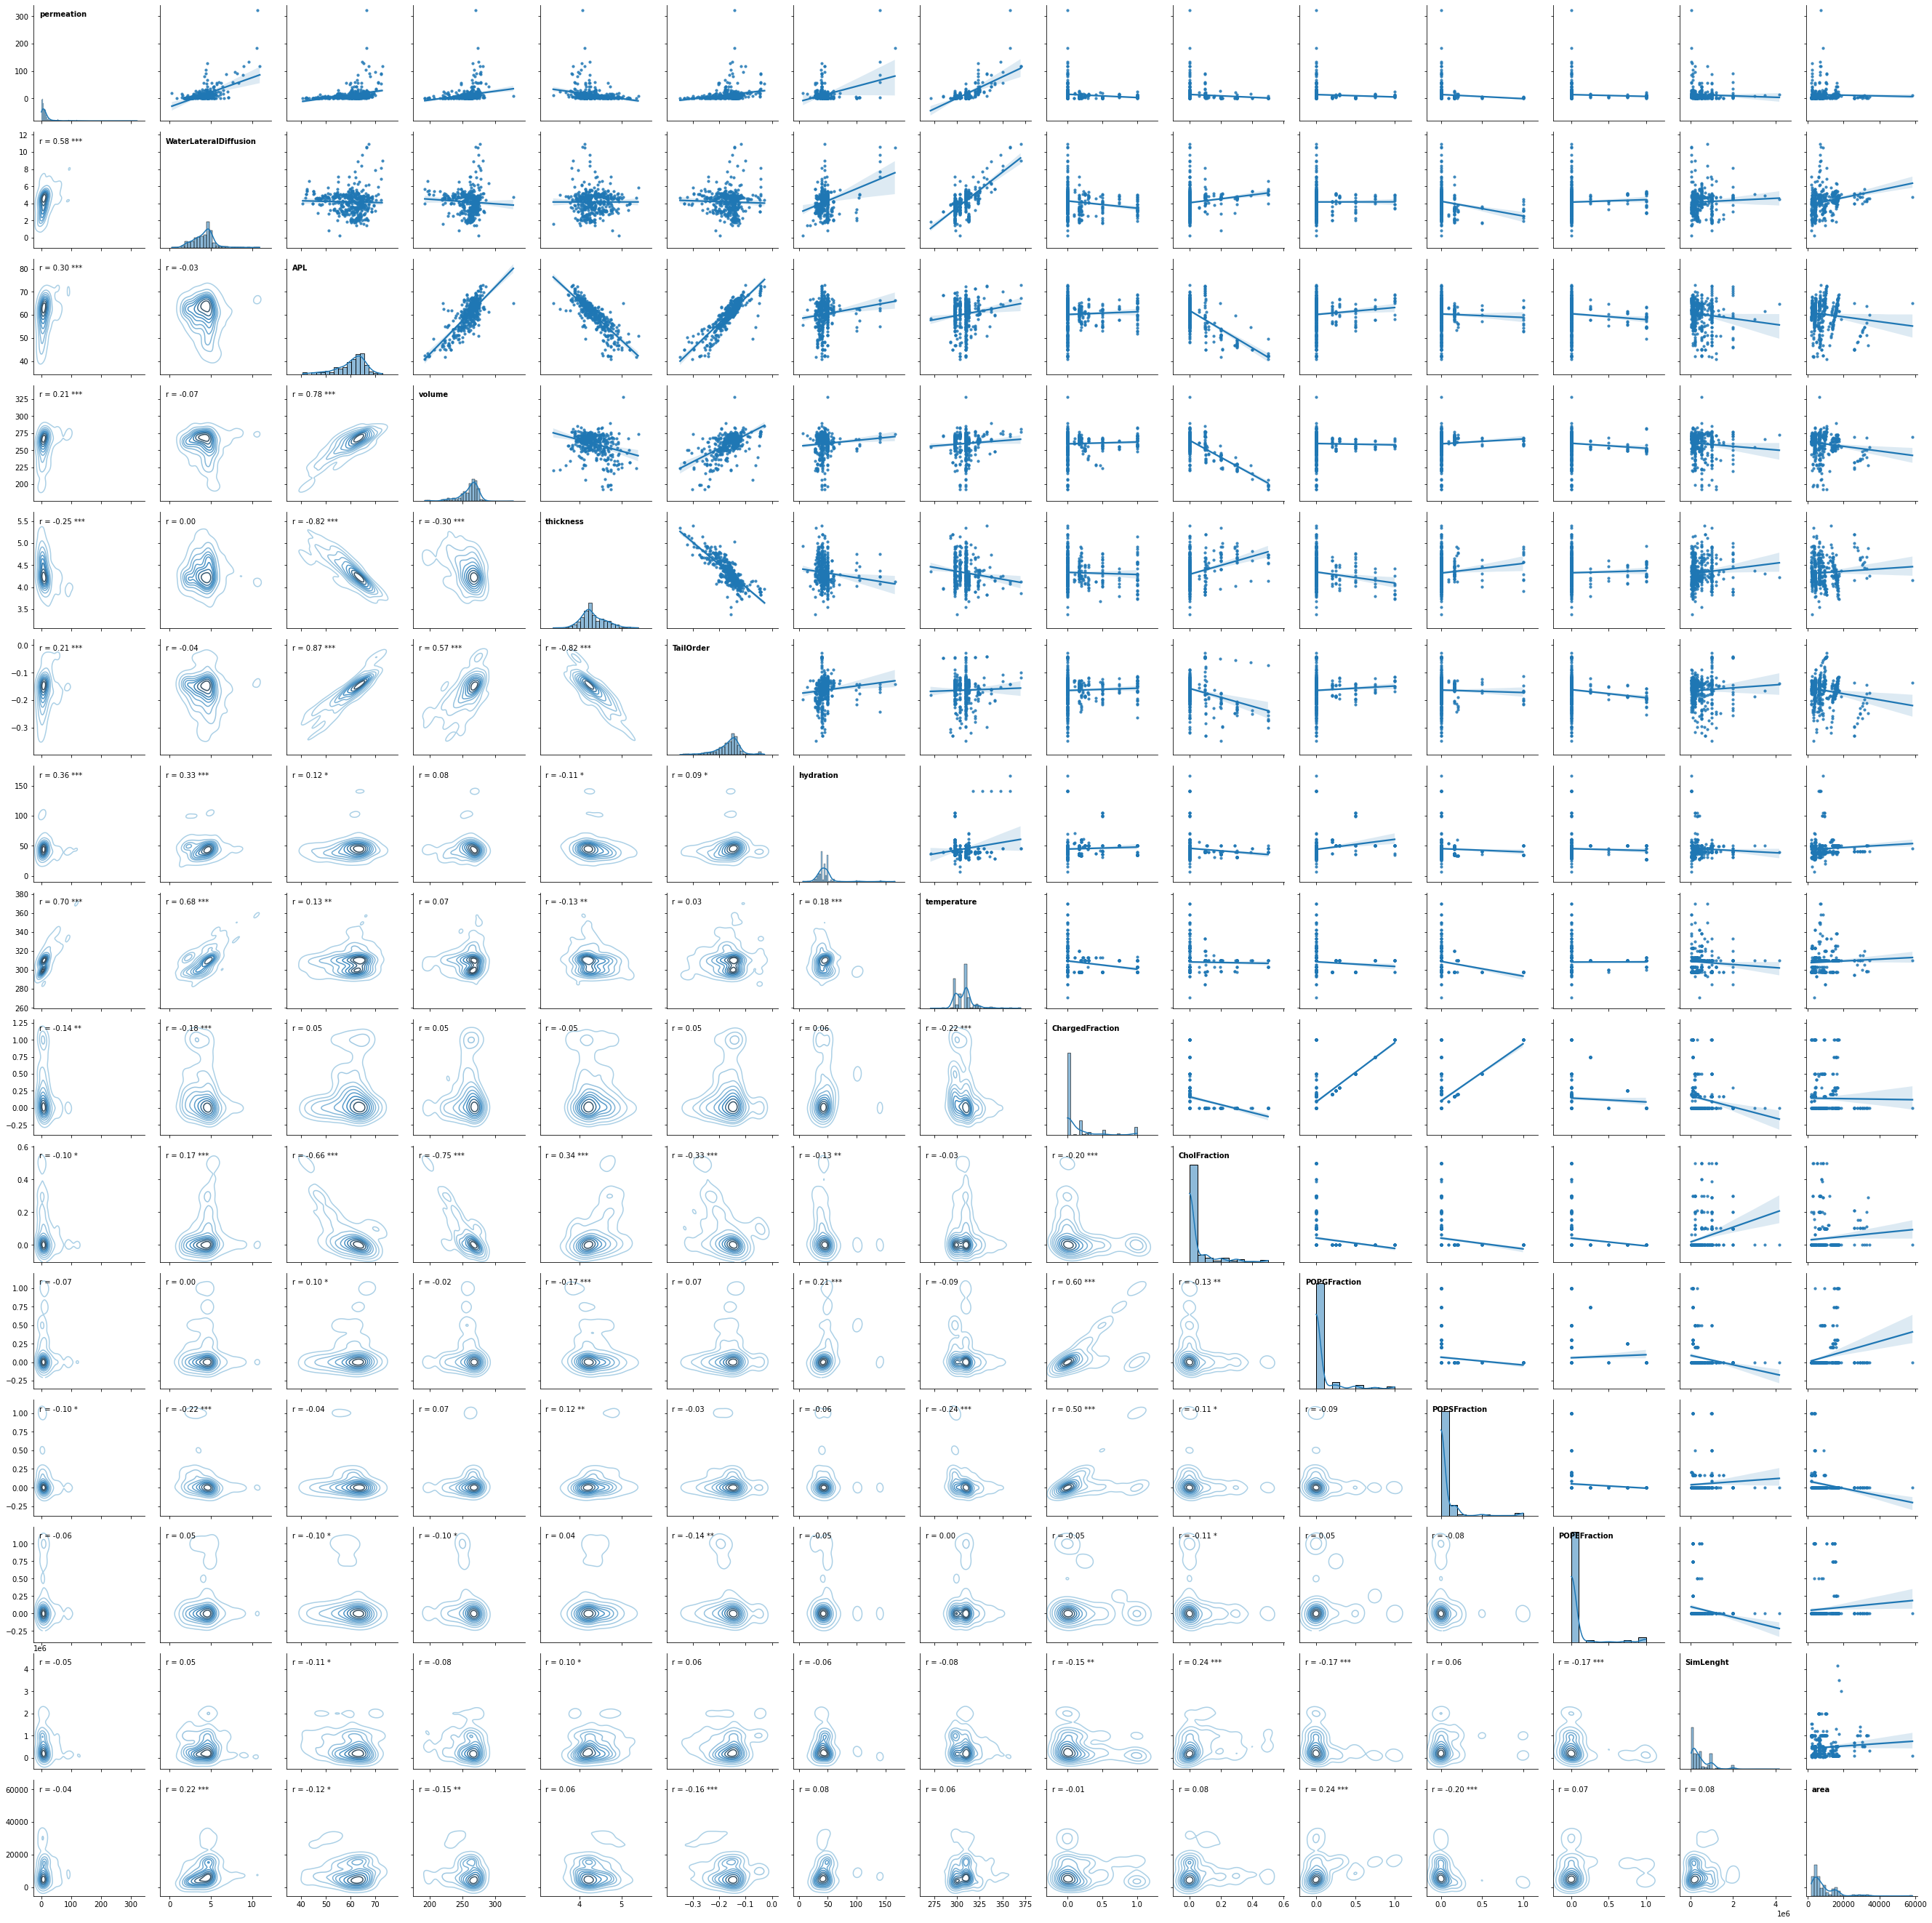

In [45]:
from scipy import stats

def corrfunc(x, y, **kws):
  r, p = stats.pearsonr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)


def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

g = sn.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
g.map_upper(sn.regplot, scatter_kws={'s':10})#, lowess = True)
g.map_diag(sn.histplot, kde= True)
g.map_diag(annotate_colname)
g.map_lower(sn.kdeplot, cmap='Blues_d')
g.map_lower(corrfunc)
# Remove axis labels, as they're in the diagonals.
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
g
g.figure.savefig("correlations.pdf")

In [ ]:
from scipy import stats

def corrfunc(x, y, **kws):
  #r, p = stats.pearsonr(x, y)
  r, p = stats.spearmanr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)


def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

g = sn.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
g.map_upper(sn.regplot, scatter_kws={'s':10}, order = 1, robust = True ) #lowess = True)
g.map_diag(sn.histplot, kde= True)
g.map_diag(annotate_colname)
g.map_lower(sn.kdeplot, cmap='Blues_d')
g.map_lower(corrfunc)
# Remove axis labels, as they're in the diagonals.
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
g
g.figure.savefig("correlations.pdf")

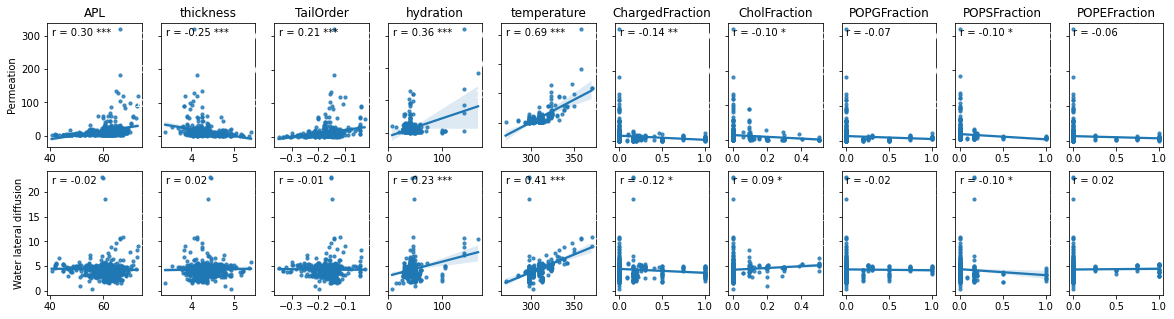

In [58]:
def CalcCorrCoeff(prop1,prop2):
    #prop1 = 'hydration'
    #prop2 = 'WaterLateralDiffusion'

    list1 = []
    list2 = []
    for ID in permeationVStemperature:
        #print(permeationVStemperature[ID])
        value1 = permeationVStemperature[ID][prop1]
        value2 = permeationVStemperature[ID][prop2]
        #if permeationVStemperature[ID][prop1] < 30:
        list1.append(value1)
        list2.append(value2)

    #print(stats.spearmanr(list1, list2))
    r, p = stats.pearsonr(list1, list2)

    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    
    ax = plt.gca()
    ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

    sn.regplot(x=list1,y=list2, scatter_kws={'s':10})
    #return r, p_stars

plt.figure(figsize=(20,5))

properties = ['APL', 
             'thickness',
             # 'volume',
             'TailOrder',
             #'sn1Order',
             #'sn2Order',
             'hydration',
              'temperature',
              'ChargedFraction',
              'CholFraction',
              'POPGFraction',
              'POPSFraction',
              'POPEFraction'
             ]

for i in range(1,11):
    #print(i)
    
    plt.subplot(2, 10, i)
    plt.title(properties[i-1])
    if i == 1:
        plt.ylabel('Permeation')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'permeation')
    
    plt.subplot(2, 10, i+10)
    if i+10 == 11:
        plt.ylabel('Water lateral diffusion')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')

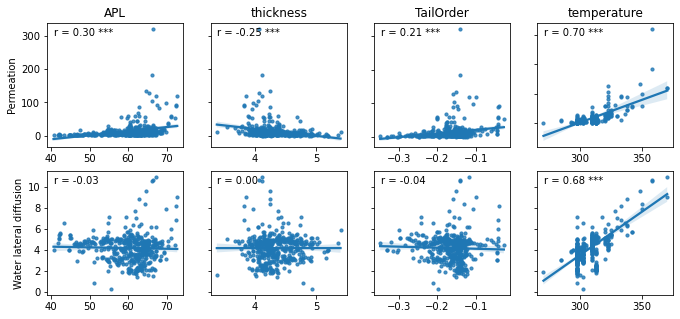

In [13]:
plt.figure(figsize=(20,5))

properties = ['APL', 
             'thickness',
             'TailOrder',
             #'hydration',
              'temperature',
              #'ChargedFraction',
              #'CholFraction',
              #'POPGFraction',
              #'POPSFraction',
              #'POPEFraction'
             ]

for i in range(1,5):
    #print(i)
    
    plt.subplot(2, 7, i)
    plt.title(properties[i-1])
    if i == 1:
        plt.ylabel('Permeation')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'permeation')
    
    plt.subplot(2, 7, i+7)
    if i+7 == 8:
        plt.ylabel('Water lateral diffusion')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')
    
plt.savefig('PermDiffDep.pdf')

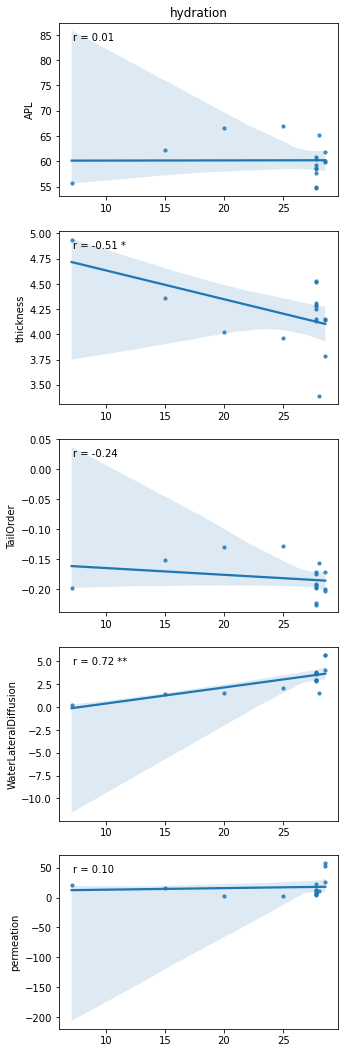

In [59]:
def CalcCorrCoeffFilterHYD(prop1,prop2):
    #prop1 = 'hydration'
    #prop2 = 'WaterLateralDiffusion'

    list1 = []
    list2 = []
    for ID in permeationVStemperature:
        #print(permeationVStemperature[ID])
        value1 = permeationVStemperature[ID][prop1]
        value2 = permeationVStemperature[ID][prop2]
        if permeationVStemperature[ID]['hydration'] < 30:
            list1.append(value1)
            list2.append(value2)

    #print(stats.spearmanr(list1, list2))
    r, p = stats.pearsonr(list1, list2)

    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    
    ax = plt.gca()
    ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

    sn.regplot(x=list1,y=list2, scatter_kws={'s':10})
    #return r, p_stars



plt.figure(figsize=(5,30))

properties = ['APL', 
             'thickness',
             'TailOrder',
              'WaterLateralDiffusion',
              'permeation'
             #'hydration',
             # 'temperature',
              #'ChargedFraction',
              #'CholFraction',
             #'POPGFraction',
             #'POPSFraction',
             #'POPEFraction'
             ]

for i in range(1,6):
    #print(i)
    
    plt.subplot(8, 1, i)
    if i ==1:
        plt.title('hydration')
    plt.ylabel(properties[i-1])
    #else:
    #    plt.yticks(color = 'w')
    CalcCorrCoeffFilterHYD('hydration',properties[i-1])
    
    #plt.subplot(2, 7, i+7)
    #if i+7 == 8:
    #    plt.ylabel('Water lateral diffusion')
    #else:
    #    plt.yticks(color = 'w')
    #CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')

In [60]:
prop1 = 'APL'
prop2 = 'permeation'

list1 = []
list2 = []
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    value1 = permeationVStemperature[ID][prop1]
    value2 = permeationVStemperature[ID][prop2]
    if permeationVStemperature[ID]['permeation'] < 0.1:
        list1.append(value1)
        list2.append(value2)

#print(stats.spearmanr(list1, list2))
r, p = stats.pearsonr(list1, list2)

p_stars = ''
if p <= 0.05:
    p_stars = '*'
if p <= 0.01:
    p_stars = '**'
if p <= 0.001:
    p_stars = '***'
    
ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

sn.regplot(x=list1,y=list2, scatter_kws={'s':10})#, order = 2)

ValueError: x and y must have length at least 2.

In [61]:
prop1 = 'thickness'
prop2 = 'permeation'

list1 = []
list2 = []
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    value1 = permeationVStemperature[ID][prop1]
    value2 = permeationVStemperature[ID][prop2]
    if permeationVStemperature[ID]['thickness'] > 3 and permeationVStemperature[ID]['permeation'] < 0.1:
        list1.append(value1)
        list2.append(value2)

#print(stats.spearmanr(list1, list2))
r, p = stats.pearsonr(list1, list2)

p_stars = ''
if p <= 0.05:
    p_stars = '*'
if p <= 0.01:
    p_stars = '**'
if p <= 0.001:
    p_stars = '***'
    
ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

sn.regplot(x=list1,y=list2, scatter_kws={'s':10})#, order = 2)

ValueError: x and y must have length at least 2.

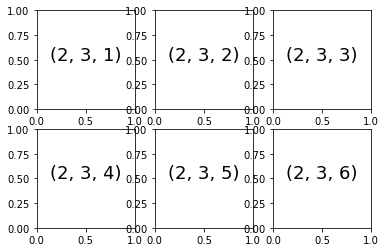

In [62]:
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.text(0.5, 0.5, str((2, 3, i)),
             fontsize=18, ha='center')

In [63]:
CHARMMsum = 0
CHARMMcount = 0
OTHERsum = 0
OTHERcount = 0


for i in permeationVStemperature:
    if permeationVStemperature[i]['temperature'] > 311:
        continue
    FF = permeationVStemperature[i]['ForceField']
    permeation = permeationVStemperature[i]['permeation']
    if 'CHARMM' in FF:
        CHARMMsum += permeation
        CHARMMcount += 1
    else:
        OTHERsum += permeation
        OTHERcount += 1
        
print(CHARMMsum/CHARMMcount, OTHERsum/OTHERcount)

10.079941567982788 6.881226234753907


In [ ]:
PermSum = 0
count = 0

for system in systems:
    try:
        rate = getWaterPermeationRate(system)
    except:
        continue
    
    POPCFraction = calcLipidFraction(system, 'POPC')
    if POPCFraction !=1:
        continue
        
    try:
        print(system['FF'],rate)
    except:
        continue
    
    if 'erger' in system['FF']:
        PermSum += rate
        count += 1
    else:
        continue

print(PermSum/count)

In [ ]:
def NagleFunct(x, a, g):
    iP = a*x[0]/(x[0]-48) + g*x[1]
    return iP

APLthick = []
permeation = []
for ID in permeationVStemperature:
    permeation.append(permeationVStemperature[ID]['permeation'])
    APLthick.append([permeationVStemperature[ID]['APL'], permeationVStemperature[ID]['thickness']])
    
scipy.optimize.curve_fit(NagleFunct, APLthick, permeation)

In [ ]:
len(APLthick)

#for i in APLthick:
#    print(NagleFunct(i,1,1))

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.sin(x[0])+b*np.cos(x[1])+c

limits = [0, 2*np.pi, 0, 2*np.pi]  # [x1_min, x1_max, x2_min, x2_max]
side_x = np.linspace(limits[0], limits[1], 100)
side_y = np.linspace(limits[2], limits[3], 100)
X1, X2 = np.meshgrid(side_x, side_y)
size = X1.shape
x1_1d = X1.reshape((1, np.prod(size)))
x2_1d = X2.reshape((1, np.prod(size)))

xdata = np.vstack((x1_1d, x2_1d))
original = (3, 1, 0.5)
z = func(xdata, *original)
Z = z.reshape(size)
z_noise = z + .2*np.random.randn(len(z))
Z_noise = z_noise.reshape(size)

ydata = z_noise
popt, pcov = curve_fit(func, xdata, ydata)
print("original: {}\nfitted: {}".format(original, popt))
z_fit = func(xdata, *popt)
Z_fit = z_fit.reshape(size)

import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
plt.title("Real Function")
plt.pcolormesh(X1, X2, Z)
plt.axis(limits)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("Function w/ Noise")
plt.pcolormesh(X1, X2, Z_noise)
plt.axis(limits)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Fitted Function from Noisy One")
plt.pcolormesh(X1, X2, Z_fit)
plt.axis(limits)
plt.colorbar()

plt.show()

In [ ]:
xdata

In [ ]:
ydata

In [ ]:
tst = np.empty([0],[0])

In [ ]:
tst

In [ ]:
np.append([1],[1])

In [ ]:
def NagleFunct(x, a, g):
    #iP = a*x[0]/(x[0]-48) + g*x[1]
    #return 1/iP
    P = a*x[0] + g*x[1]
    return P
    

APL = []
thick = []
permeation = []
for ID in permeationVStemperature:
    permeation.append(permeationVStemperature[ID]['permeation'])
    APL.append(permeationVStemperature[ID]['APL'])
    thick.append(permeationVStemperature[ID]['thickness']*10)

x = np.asarray(APL)
y = np.asarray(thick)
X1, X2  = np.meshgrid(x,y)
#size = X1.shape
#x1_1d = X1.reshape((1, np.prod(size)))
#x2_1d = X2.reshape((1, np.prod(size)))
#xdata = np.vstack((X1, X2))
xdata = np.vstack((x, y))


ydata = np.asarray(permeation)
#ydata = ydata.reshape(size)

scipy.optimize.curve_fit(NagleFunct, xdata, ydata)

In [ ]:
xdata

In [ ]:
theo = []
sim = []
for i in range(len(APL)):
    theo.append(NagleFunct([APL[i],thick[i]], 0.38478557, -0.30789772))
    sim.append(permeation[i])
    #print(theo[i],sim[i])
plt.plot(theo,sim,".")
plt.ylim(0,20)
plt.xlim(0,20)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(APL)):
    ax.scatter(thick[i],APL[i],permeation[i])
#for angle in range(0, 360):

y = np.linspace(30, 60, 30)
x = np.linspace(50, 70, 30)

X, Y = np.meshgrid(x, y)
#Z = f(X, Y)
Z = NagleFunct((X,Y), 0.38478557, -0.30789772)

ax.contour3D(Y, X, Z, 50, cmap='binary')
ax.view_init(20, 20)
ax.set_zlim(0,20)
#plt.draw()
#plt.pause(.001)

In [ ]:
Y

In [ ]:
xmin, xmax, nx = -5, 4, 75
ymin, ymax, ny = -3, 7, 150
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

In [ ]:
np.meshgrid(x, y)


In [ ]:
#xprop = 'temperature'
yprop = 'permeation'
#yprop = 'WaterLateralDiffusion'
xprop = 'thickness'

avetemp = {}
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    temperature = round(permeationVStemperature[ID][xprop], 1)
    if temperature not in avetemp.keys():
        avetemp[temperature] = {}
        avetemp[temperature]['values'] = []
        avetemp[temperature]['weigths'] = []
    avetemp[temperature]['values'].append(permeationVStemperature[ID][yprop])
    avetemp[temperature]['weigths'].append(permeationVStemperature[ID]['SimLenght']) 
    #print(permeationVStemperature[ID]['permeation'], permeationVStemperature[ID]['temperature'])
    
for temp in avetemp:
    average = np.average(avetemp[temp]['values'], weights = avetemp[temp]['weigths'])
    #plt.plot(1/temp, np.log(average),".")
    plt.plot(temp, average,".")

In [ ]:
avetemp

In [36]:
mini= 100
for ID in permeationVStemperature:
    if permeationVStemperature[ID]['permeation'] > mini:
        mini = permeationVStemperature[ID]['permeation']
print(mini)

321.68545906037696
